In E-Commerce or retail business, the relationship between businesses and customers are non-contractual relationship. In the non-contractual world, customers do go away, but they do so silently; they have no need to tell us they are leaving. This makes for a much trickier CLV calculation. We have to look at the time since a customer’s last transaction and ask a question: is the customer alive but dormant, or is the customer “dead” (“alive” means customers interact with us, “die” means they become inactive as customers)?

So, here we are: modelling customer lifetime value for non-contractual business.

The analysis is drawn upon Dr. Peter Fader of Wharton. We will not dive deeply into the math of CLV in this analysis. However, if you are interest, here is the Paper.

#### Import Packages, reading the csv data into pandas dataframe for further manipulations and measures.

In [33]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv("sales_data.csv")
df.head()

,Unnamed: 0,InvoiceNo,StockCode,Quantity Shipped,Year,Invoice Date,UnitPrice,Ext-Price,CustomerID,Country,GM%,Shipper,COST,EXT COST,REGION,SALES P,OrderPeriod
0,0,568200,PADS,5.00,"2,017",2017-09-25 00:00:00+00:00,1.0,$5.00,16198,United Kingdom,0%,Delivery Truck,1.0,4.999763,SOUTH,GRACE J,2017-09
1,1,568375,BANK CHARGES,5.00,"2,017",2017-09-26 00:00:00+00:00,1.0,$5.00,13405,United Kingdom,100%,UPS Next day Air,0.0,0.000000,WEST,JEFF Y,2017-09
2,2,561226,PADS,5.00,"2,017",2017-07-26 00:00:00+00:00,1.0,$5.00,15618,United Kingdom,0%,Delivery Truck,1.0,4.999763,SOUTH,GRACE J,2017-07
3,3,2550193,PADS,7.08,"2,018",2018-06-08 00:00:00+00:00,1.0,$7.08,13952,United Kingdom,0%,UPS ground 2nd day,1.0,7.079664,CENTRAL,PETER T,2018-06
4,4,550193,PADS,5.00,"2,017",2017-04-15 00:00:00+00:00,1.0,$5.00,13952,United Kingdom,0%,UPS ground 2nd day,1.0,4.999763,CENTRAL,PETER T,2017-04


In [34]:
df.columns

Index(['Unnamed: 0', 'InvoiceNo', 'StockCode', 'Quantity Shipped', ' Year ',
       'Invoice Date', 'UnitPrice', ' Ext-Price ', 'CustomerID', 'Country',
       'GM%', 'Shipper', 'COST', 'EXT COST', 'REGION', 'SALES P',
       'OrderPeriod'],
      dtype='object')

As usual, we have some cleaning to do, then create a new dataframe that only contains CustomerID, InvoiceDate (remove the time) and add a new column — sales:

In [35]:
import datetime as dt
df['Invoice Date'] = pd.to_datetime(df['Invoice Date']).dt.date
df = df[pd.notnull(df['CustomerID'])]
df = df[(df['Quantity Shipped']>0)]
df['Sales'] = df['Quantity Shipped'] * df['UnitPrice']
cols_of_interest = ['CustomerID', 'Invoice Date', 'Sales']
df = df[cols_of_interest]
print(df.head())

print(df['CustomerID'].nunique())

   CustomerID Invoice Date  Sales
0       16198   2017-09-25   5.00
1       13405   2017-09-26   5.00
2       15618   2017-07-26   5.00
3       13952   2018-06-08   7.08
4       13952   2017-04-15   5.00
4146


### CLV Model Definition
<br>
**For the CLV models, the following nomenclature is used:**
<br>

> * *Frequency represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases.*
<br>

> * *T represents the age of the customer in whatever time units chosen (daily, in our dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.*
<br>
> * *Recency represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)*
<br>

**The following analysis is conducted in Python using Lifetimes packagedeveloped by Cameron Davidson-Pilon, data scientist at Shopify**
<br>

### Data Exploration

In [15]:
!pip install lifetimes --user

  Using cached https://files.pythonhosted.org/packages/32/a7/0769293ffd5757bdbb626167b4361e46d353b028b4045a82aa2bae20e17e/Lifetimes-0.10.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/b9/a2/62f77d2d3c42364d45ba714b4bdf7e1c4dfa67091dc9f614fa5a948b4fb4/scipy-1.2.1-cp36-cp36m-win_amd64.whl


You are using pip version 18.1, however version 19.0.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [36]:
df.dtypes

CustomerID        int64
Invoice Date     object
Sales           float64
dtype: object

In [45]:
df.head()

,CustomerID,Invoice Date,Sales
0,16198,2017-09-25,5.00
1,13405,2017-09-26,5.00
2,15618,2017-07-26,5.00
3,13952,2018-06-08,7.08
4,13952,2017-04-15,5.00


In [42]:
df = df[pd.notnull(df['Invoice Date'])]

In [43]:
df['Invoice Date'] = pd.to_datetime(df['Invoice Date'])

In [44]:
#from lifetimes.plotting import *
#from lifetimes.utils import *
#from lifetimes.estimation import *
#data = summary_data_from_transaction_data(df, 'CustomerID', 'Invoice Date', monetary_value_col='Sales')
#data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346,1.0,476.0,708.0,750573.402500
12347,62.0,729.0,750.0,238.856391
12348,14.0,729.0,741.0,393.476198
12349,0.0,0.0,401.0,0.000000
12350,15.0,545.0,693.0,52.030497


There are 4146 customers under our analysis.

CustomerID 12346 made 2 purchase only, so his frequency and recency are 1 and 476 respectively, and his age is 708 days (e.g. the duration between his first purchase and the end of the period in the analysis).

In [46]:
data['frequency'].plot(kind='hist', bins=50)
print(data['frequency'].describe())
print(sum(data['frequency'] == 0)/float(len(data)))

count    4146.000000
mean       26.686204
std        46.482316
min         0.000000
25%         1.000000
50%         9.000000
75%        32.000000
max       433.000000
Name: frequency, dtype: float64
0.223589001447178


Among all customers in our data, more than 22.36% of them only made purchase once (no repeat).

### Frequency/Recency Analysis Using the BG/NBD Model

In [47]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4146 subjects, a: 0.66, alpha: 8.56, b: 60.34, r: 0.38>


### Visualizing our frequency/recency matrix


*Consider: a customer has made purchase every day for four weeks straight, and then we haven’t heard from him in months. What are the chances he is still “alive”? Pretty small, right? * 
<br> 

*On the other hand, a customer who historically made purchase once a quarter, and again last quarter, is likely still alive. We can visualize this relationship using the frequency/recency matrix, which computes the expected number of transactions an artificial customer is to make in the next time period, given his recency (age at last purchase) and frequency (the number of repeat transactions he has made).*

In [52]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
%matplotlib inline


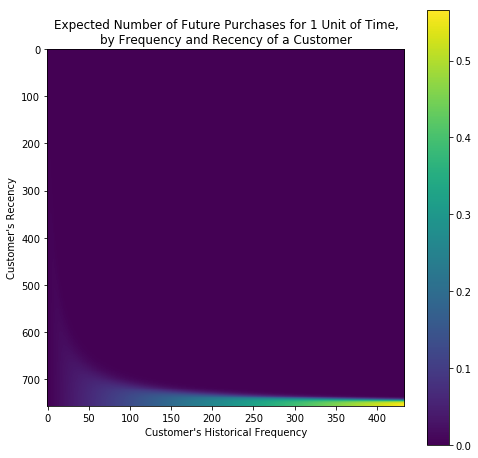

In [51]:
fig = plt.figure(figsize=(8,8))
plot_frequency_recency_matrix(bgf)

In [75]:
data[data['frequency'] >400]

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14911,411.0,750.0,755.0,1430.588113,0.527518
17841,433.0,754.0,756.0,904.088685,0.564267


> * If a customer has made 400 and more purchases, and his latest purchase was when he was approximately 700 days old (i.e. Recency: the duration between her first transaction and her latest transaction is 700 days), then they are our best customers (bottom-right).

> * Customers who have purchased a lot and purchased recently will likely be the best customers in the future. We will never have enough of them.

> * Customers who have purchased a lot but not recently (top-right corner), have probably gone.

> * There are also another type of customers that around (40, 650) that represents the customer who buys infrequently, and we have not seen him recently, so he might buy again. However, we are not sure if he has gone or just between purchases.

**We can predict which customers are surely alive:**

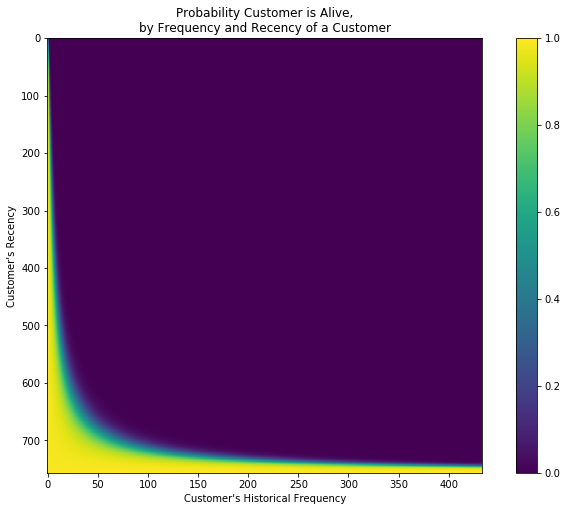

In [59]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

*Customers who have purchased recently are almost surely “alive”.*

*Customers who have purchased a lot but not recently, are likely to have dropped out. And the more they bought in the past, the more likely they have dropped out. They are represented in the upper-right.*

*We are ranking customers from “highest expected purchases in the next period” to lowest. Models expose a method that will predict a customer’s expected purchases in the next period using their history.*


In [60]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
12748,348.0,751.0,755.0,556.528942,0.451530
15311,361.0,752.0,756.0,469.304420,0.467602
14606,396.0,750.0,752.0,504.695996,0.518837
14911,411.0,750.0,755.0,1430.588113,0.527518
17841,433.0,754.0,756.0,904.088685,0.564267


In [135]:
data.to_csv("RFM_customer_data.csv")

* Listed above are our top 5 customers that the model expects them to make purchases in the next day. 

* The predicted_purchases column represents their expected number of purchases while the other three columns represent their current RF metrics. 

* The BG/NBD model believes these individuals will be making more purchases within the near future as they are our current best customers.

### Assessing model fit



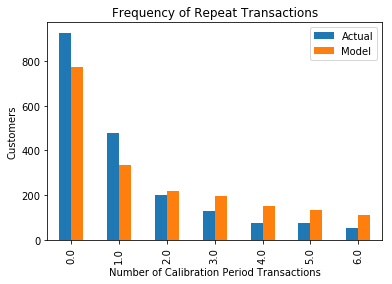

In [61]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

Not bad, out model does not suck. So, we can continue on with our analysis.

We now partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (just like cross-validation in machine learning practice).

In [68]:
from lifetimes.utils import calibration_and_holdout_data
summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'Invoice Date',
                                        calibration_period_end='2018-10-31',
                                        observation_period_end='2018-12-27' )   
print(summary_cal_holdout.head())

            frequency_cal  recency_cal  T_cal  frequency_holdout  \
CustomerID                                                         
12346                 1.0        476.0  651.0                0.0   
12347                58.0        665.0  693.0                4.0   
12348                13.0        606.0  684.0                1.0   
12349                 0.0          0.0  344.0                0.0   
12350                15.0        545.0  636.0                0.0   

            duration_holdout  
CustomerID                    
12346                     57  
12347                     57  
12348                     57  
12349                     57  
12350                     57  


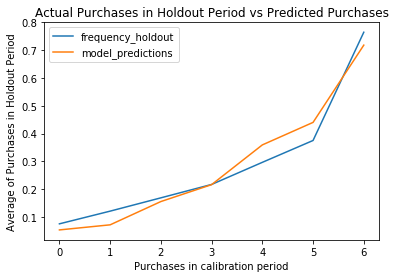

In [69]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In this plot, we separate the data into both a in-sample (calibration) and validation (holdout) period. The sample period consists the beginning to 2018–10–30; the validation period spans from 2018–11–01 to 2011–12–27. The plot groups all customers in the calibration period by their number of repeat purchases (x-axis) and then averages over their repeat purchases in the holdout period (y-axis). The green and blue line presents the model prediction and actual result of the y-axis respectively. As we can see, our model is able to very accurately predict the customer base’s behaviour out of the sample, the model overestimates after 3 purchases and under predicts at 6 purchases

### Customer transactions predictions
**Based on customer history, we can now predict what an individual’s future purchases might look like:**



In [82]:
t = 10
individual = data.loc[17841]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

5.66557062183062

*Our model predicts that customer 17841’s expected no. of purchases is 5.67 in the next 10 days.*

### Customer probability histories
*Given a customer transaction history, we can calculate their historical probability of being alive, according to our trained model. For example, we want to look at our best customer’s transactions history and see the probability of being alive:*

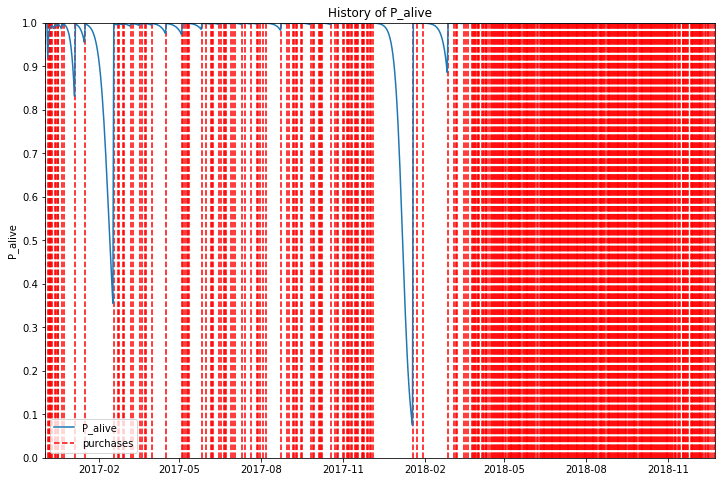

In [84]:
from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
id = 12748
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'Invoice Date')

In [117]:
data.sort_values(by='predicted_purchases').head(40)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
17602,84.0,342.0,504.0,150.619211,4.282911e-13
15922,231.0,605.0,695.0,562.072669,2.546860e-12
15464,106.0,546.0,721.0,95.202243,7.783238e-12
17537,49.0,177.0,318.0,49.155738,1.873274e-11
12501,93.0,524.0,698.0,146.488741,1.044325e-10
18212,35.0,177.0,344.0,57.007818,1.967885e-09
16222,90.0,545.0,701.0,160.553886,5.179283e-09
17555,32.0,177.0,350.0,60.666564,6.808994e-09
17609,92.0,560.0,710.0,57.149990,1.189705e-08


#### Our best customer is definitely alive, however, he had several hiatus in the first quarter of each year.

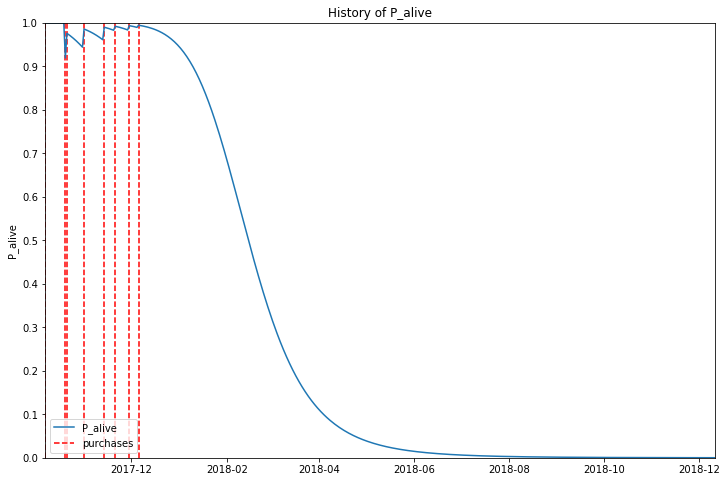

In [126]:
fig = plt.figure(figsize=(12,8))
id = 13755
days_since_birth = 430
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'Invoice Date')

On the other hand, this customer had only purchased once and has dropped off for a long time with a 100% chance that he is dead.

Estimating customer lifetime value using gamma-gamma model of monetary value
We are now taking into account the economic value of each transaction. To estimate this we use the Gamma-Gamma submodel presented by Dr. Peter Fader and Dr. Bruce Hardie from Wharton, to predict likely spend per transaction in the future at the customer level.

We are only estimating the customers who had at least one repeat purchase with us. Therefore, we are estimating for 3,219 customers.

In [127]:
returning_customers_summary = data[data['frequency']>0]
print(returning_customers_summary.head())
print(len(returning_customers_summary))

            frequency  recency      T  monetary_value  predicted_purchases
CustomerID                                                                
12346             1.0    476.0  708.0   750573.402500             0.001893
12347            62.0    729.0  750.0      238.856391             0.079720
12348            14.0    729.0  741.0      393.476198             0.018970
12350            15.0    545.0  693.0       52.030497             0.016364
12352            16.0    579.0  679.0       98.164835             0.021366
3219


In [128]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 3219 subjects, p: 0.52, q: 1.67, v: 402.53>


After applying Gamma-Gamma model, now we can estimate average transaction value for each customer. Phew!

In [132]:
Avg_transaction_customer = ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).sort_values(ascending = False)

In [133]:
Avg_transaction_customer.to_csv("Average_transaction_by_each_customer.csv")

In [134]:
Avg_transaction_customer.head()

CustomerID
12346    325471.697223
15098    169096.815761
13452     25795.879589
14096     14137.949299
15510     12055.592730
dtype: float64

In [136]:
t = 10
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
12748,348.0,751.0,755.0,556.528942,4.558707
15311,361.0,752.0,756.0,469.304420,4.722542
14606,396.0,750.0,752.0,504.695996,5.209137
14911,411.0,750.0,755.0,1430.588113,5.379681
17841,433.0,754.0,756.0,904.088685,5.665571


In [138]:
data.to_csv("customer_predicted_purchases_in_next_10_days.csv")